In [2]:
import perceval as pcvl
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from utils import MNIST_partial, accuracy, plot_training_metrics
import matplotlib.pyplot as plt
from feature_map import simulate_quantum_image

# Feature map: from classic to quantum
you can consider the feature map as a quantum data loader, it convert the classic image to quantum state so that we can implement our quantum components.

# Problem: an example of the image data we can use for quantum 

  0%|          | 0/6000 [00:00<?, ?it/s]

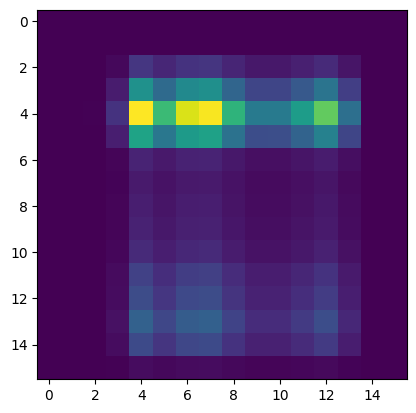

  0%|          | 0/6000 [00:01<?, ?it/s]

tensor([0])


In [3]:
# dataset from csv file, to use for the challenge
train_dataset = MNIST_partial(split = 'train')
val_dataset = MNIST_partial(split='val')

# definition of the dataloader, to process the data in the model
# here, we need a batch size of 1 to use the boson sampler
batch_size = 1
reduced_size = 16
samples = 1000
postselect = 1
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_loader = DataLoader(train_dataset, batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size, shuffle = False)

for step, batch in enumerate(tqdm(train_loader)):
    images, labs = batch
    image = simulate_quantum_image(images, reduced_size, samples, postselect, device)
    plt.imshow(image.squeeze())
    plt.show()
    print(labs)
    break

## The problem is mainly in the method tensor_decomposition()
We want the relative rank of elements become stable. That means For i,j,k,l in [0,N], if the element C_ij is larger than the element C_kl in the classic image, then the the element C_ij should also larger than the element C_kl should in the quantum image.

You can observe the evaluate_rank_consistency() method above, the result is not very well, we want to minimize the value.

In [37]:
from torch.nn import AdaptiveAvgPool2d

def evaluate_rank_consistency(classic_image, quantum_image):
    N = classic_image.shape[0]
    bad_rank_count = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                for l in range(N):
                    # Check the condition
                    if (classic_image[i, j] > classic_image[k, l]) and not (quantum_image[i, j] > quantum_image[k, l]):
                        bad_rank_count += 1

    return bad_rank_count


for step, batch in enumerate(tqdm(train_loader)):
    image, labs = batch
    image = image.squeeze()[2:-2, 2:-2].unsqueeze(0)
    adaptive_avg_pool = AdaptiveAvgPool2d((reduced_size, reduced_size))
    image = adaptive_avg_pool(image).to(device).squeeze()
    quantum_image = simulate_quantum_image(image, reduced_size, samples, postselect, device)
    print(evaluate_rank_consistency(quantum_image, image.squeeze()))
    break

  0%|          | 0/6000 [00:02<?, ?it/s]

16331
